Solve for homogeneous Poisson problems using FEANet framework 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import h5py
import meshio
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshSquare
from FEANet.model import KNet, FNet
from FEANet.jacobi import JacobiBlockPBC
from Utils import plot

In [2]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, n, f = None, size=2.0):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.grid = MeshSquare(size, nnode_edge=n+1)
        self.InstantiateFEANet()
        self.jac = JacobiBlockPBC(self.grid, self.Knet, self.omega)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)

        if(f is None):
            f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = self.fnet(self.jac.pbc_boundary(f)) # due to padding = 1, the output size is n+3 rather than n+1

    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, initial_v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = initial_v
        for i in range(num_sweeps_down):
            v = self.jac.jacobi_convolution(v, f)
        return v


In [3]:
# Problem parameters
n = 2**5

x = torch.linspace(-1,1,n+1)
y = torch.linspace(-1,1,n+1)
xx, yy = torch.meshgrid(x, y, indexing='ij')

rhs = torch.sin(1.*torch.pi*(xx+0.5))*torch.cos(1.*torch.pi*(yy)).reshape((1,1,n+1,n+1))
prob = SingleGrid(n, rhs)

RHS:


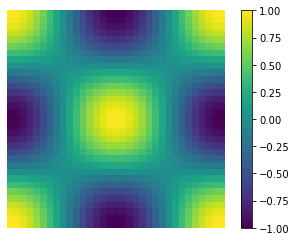

In [4]:
print("RHS:")
plot.plot_field(rhs.detach())

In [5]:
EPS = 1e-6
n_jacobi = 0
u_jacobi = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
u_jacobi_pbc = prob.jac.pbc_boundary(u_jacobi)

residual = prob.f-prob.Knet(u_jacobi_pbc)
u_jacobi = prob.jac.reset_boundary(u_jacobi)
res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
res_jacobi = [res]
print(n_jacobi, res)

while (res > EPS):
    u_jacobi = prob.Relax(u_jacobi, prob.f, 1)
    u_jacobi_pbc = prob.jac.pbc_boundary(u_jacobi)
    residual = prob.f-prob.Knet(u_jacobi_pbc)
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_jacobi.append(res)
    n_jacobi += 1
    print(n_jacobi, res)

0 0.06555832177400589
1 0.06430670619010925
2 0.06307899206876755
3 0.06187470629811287
4 0.0606934130191803
5 0.05953467637300491
6 0.058398064225912094
7 0.05728314816951752
8 0.05618951469659805
9 0.055116765201091766
10 0.054064493626356125
11 0.05303231254220009
12 0.052019841969013214
13 0.05102669075131416
14 0.05005251243710518
15 0.04909692704677582
16 0.048159580677747726
17 0.047240134328603745
18 0.046338241547346115
19 0.04545356705784798
20 0.04458578675985336
21 0.04373456910252571
22 0.04289960488677025
23 0.042080581188201904
24 0.0412771962583065
25 0.04048914462327957
26 0.039716143161058426
27 0.03895789757370949
28 0.038214124739170074
29 0.0374845527112484
30 0.03676890581846237
31 0.0360669307410717
32 0.0353783518075943
33 0.03470292314887047
34 0.034040383994579315
35 0.03339049592614174
36 0.03275301679968834
37 0.032127708196640015
38 0.03151432424783707
39 0.030912671238183975
40 0.030322497710585594
41 0.02974359132349491
42 0.029175736010074615
43 0.028618

Solution converges after  576 Weighted Jacobi iterations
Solution:


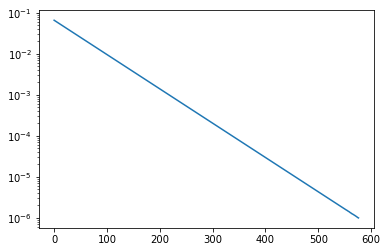

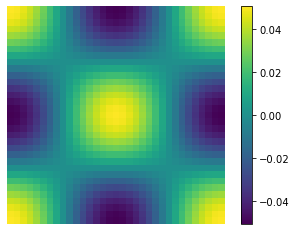

In [6]:
print("Solution converges after ", n_jacobi, "Weighted Jacobi iterations")

plt.plot(res_jacobi)
plt.yscale('log')

print("Solution:")
plot.plot_field(u_jacobi.detach())
